In [1]:
# init
import pandas as pd
import numpy as np
from tqdm import tqdm
# import nltk
# nltk.download()

Import Data

In [2]:
import glob
import os

In [ ]:
# import pubmed
pubmed = []
docList = glob.glob(os.path.join(os.getcwd(), "Datasets/pubmed/", "*.txt"))

for docPath in tqdm(docList):
    # get doc file name
    docName = os.path.basename(docPath).split('.')[0]
    className = docName[:3]
    
    with open(docPath, encoding="utf8") as doc:
        # insert [class, docs, feature]
        pubmed.append([className, docName, doc.read().replace('\n', ' ')])

# # make dataframe
# dataframe = pd.DataFrame(data=pubmed, columns=['class', 'document', 'feature']) 

# # export pubmed raw
# dataframe.to_csv('pubmed/raw.csv', index=False)

In [ ]:
# import scopus
scopus = []
docList = glob.glob(os.path.join(os.getcwd(), "Datasets/scopus/", "*"))

for docPath in tqdm(docList):
    # get doc file name
    docName = os.path.basename(docPath)
    className = docName.split('-')[0]
    
    with open(docPath, encoding="utf8") as doc:
        # insert [class, docs, feature]
        scopus.append([className, docName, doc.read().replace('\n', ' ')])

# make dataframe
dataframe = pd.DataFrame(data=scopus, columns=['class', 'document', 'feature']) 

# export pubmed raw
dataframe.to_csv('scopus/raw.csv', index=False)

Dataframe Raw

In [ ]:
# read csv
pubmedRaw = pd.read_csv('pubmed/raw.csv')
scopusRaw = pd.read_csv('scopus/raw.csv')

# get feature
pubmedFeatures = pubmedRaw.loc[:, 'feature']
scopusFeatures = scopusRaw.loc[:, 'feature']
scopusFeatures

Preprocesing

In [6]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# cleaning
def cleaning(features):
    result = []
    for feature in features:
        regex = re.sub(r'[^a-zA-Z\s]', '', feature)
        result.append(regex)
    return result

# case folding
def caseFolding(features):
    result = []
    for feature in features:
        lower = feature.lower()
        result.append(lower)
    return result

# tokenization
def tokenization(features):
    result = []
    for feature in features:
        token = word_tokenize(feature)
        result.append(token)
    return result

# stopwords removal
def stopWords(features):
    result = []
    stopWords = set(stopwords.words('english'))
    for token in features:
        cleanedFeature = [feature for feature in token if feature not in stopWords]
        result.append(cleanedFeature)
    return result

In [35]:
# preprocessing
def preprocessing(features):
    clean = cleaning(features)
    case = caseFolding(clean)
    token = tokenization(case)
    preprocessed = stopWords(token)
    return preprocessed
    
pubmedPreprocessed = preprocessing(pubmedFeatures)
scopusPreprocessed = preprocessing(scopusFeatures)
# print(scopusPreprocessed[0])

# export pubmed clean
for i in range(len(pubmedPreprocessed)):
    pubmedRaw.loc[i, 'feature'] = ' '.join(pubmedPreprocessed[i])
pubmedRaw.to_csv('pubmed/clean.csv', index=False)

# export scopus clean
for i in range(len(scopusPreprocessed)):
    scopusRaw.loc[i, 'feature'] = ' '.join(scopusPreprocessed[i])
scopusRaw.to_csv('scopus/clean.csv', index=False)

Daraframe Clean

In [ ]:
# read csv
pubmedClean = pd.read_csv('pubmed/clean.csv')
scopusClean = pd.read_csv('scopus/clean.csv')

# get feature
pubmedFeatures = pubmedClean.loc[:, 'feature']
scopusFeatures = scopusClean.loc[:, 'feature']
scopusClean

Feature Forming

In [ ]:
from textblob import TextBlob

def featureForming(features, dataframe):
    # BOAW
    dataframe.rename(columns={'feature': 'BOAW'}, inplace=True)
    for i in tqdm(range(len(features))):
        # BON
        dataframe.loc[i, 'BON'] = ' '.join(TextBlob(features[i]).noun_phrases)
        # BONA
        dataframe.loc[i, 'BONA'] = ' '.join([word for (word, tag) in TextBlob(features[i]).tags if tag[:2]=='NN' or tag[:2]=='JJ'])

featureForming(pubmedFeatures, pubmedClean)
featureForming(scopusFeatures, scopusClean)
# print(scopusClean)

pubmedClean.to_csv('pubmed/formed.csv', index=False)
scopusClean.to_csv('scopus/formed.csv', index=False)

Dataframe Formed

In [2]:
# read csv
pubmedFormed = pd.read_csv('pubmed/formed.csv')
scopusFormed = pd.read_csv('scopus/formed.csv')

# get feature
pubmedClass = pubmedFormed.loc[:, 'class']
pubmedBoaw = pubmedFormed.loc[:, 'BOAW']
pubmedBon = pubmedFormed.loc[:, 'BON']
pubmedBona = pubmedFormed.loc[:, 'BONA']

scopusClass = scopusFormed.loc[:, 'class']
scopusBoaw = scopusFormed.loc[:, 'BOAW']
scopusBon = scopusFormed.loc[:, 'BON']
scopusBona = scopusFormed.loc[:, 'BONA']
scopusFormed

,class,document,BOAW,BON,BONA
0,CONCRETE,CONCRETE-2015-1,modeling diffusion sulfate concrete using mixt...,diffusion sulfate mixture theory springerverla...,diffusion sulfate concrete mixture theory spri...
1,CONCRETE,CONCRETE-2015-10,experimental study flexural behavior recycled ...,experimental study flexural behavior coarse ag...,experimental study flexural behavior coarse ag...
2,CONCRETE,CONCRETE-2015-100,shaking table test numerical analysis highrise...,table test numerical analysis highrise buildin...,table test numerical analysis highrise buildin...
3,CONCRETE,CONCRETE-2015-101,stateoftheart literature review concrete mesos...,stateoftheart literature review concrete mesos...,stateoftheart literature review concrete mesos...
4,CONCRETE,CONCRETE-2015-102,flexural tensile properties plastic concrete r...,flexural tensile properties plastic concrete r...,flexural tensile properties concrete paper pre...
...,...,...,...,...,...
2795,TECTONICPLATES,TECTONICPLATES-2015-95,playing jigsaw large igneous provinces plate t...,large igneous provinces plate tectonic reconst...,jigsaw large igneous provinces tectonic recons...
2796,TECTONICPLATES,TECTONICPLATES-2015-96,tidal sensitivity tectonic tremors nankai casc...,tidal sensitivity tectonic tremors nankai casc...,tidal sensitivity tectonic tremors cascadia su...
2797,TECTONICPLATES,TECTONICPLATES-2015-97,focal mechanisms tectonic stress field northso...,focal mechanisms tectonic stress field northso...,focal mechanisms tectonic stress field seismic...
2798,TECTONICPLATES,TECTONICPLATES-2015-98,seismic anisotropy crust northeast margin tibe...,seismic anisotropy crust tibetan plateau tecto...,seismic anisotropy crust margin tibetan platea...


Feature Selection

In [3]:
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import spdiags

In [4]:
# TF-RF
def tf_rf(features, classes):
    # get tf weights
    tfVec = CountVectorizer()
    tf = tfVec.fit_transform(features)

    # get classes weights
    clsVec = LabelBinarizer()
    cls = clsVec.fit_transform(classes)

    if cls.shape[1] == 1:
        cls = np.append(1 - cls, cls, axis=1)

    # count rf
    feature = ((cls.T * tf) > 0).astype(np.float64)

    for i in range(cls.shape[1]):
        # feature.sum(axis=0) - feature[i] is the sum of all rows except i
        feature[i] /= np.maximum(1., feature.sum(axis=0) - feature[i])

    rf = np.mean(np.log2(2 + feature, out=feature), axis=0)

    # count tf-rf & transform
    n_features = rf.shape[0]
    tfRf = tf * spdiags(rf, 0, n_features, n_features)

    # define weights into dataframe
    featureName = tfVec.get_feature_names_out()
    featureWeight = tfRf.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    df.loc[:, 'class'] = classes
    # return df

    # count weight by class
    mean = df.groupby('class').mean()
    result = (mean/mean.max()).sum()
    # print(result)

    # select minimum weighted features
    selected = []
    for i in range(len(result)):
        if result[i] != 0 and result[i] == np.min(result):
            selected.append(df.columns[i])
    return selected

# rfx = tf_rf(bona, classes)
# print(rfx)

# SFS
# def sfs():

# Symbolic Relevance
def symbolic_relevance(features, classes):
    # get sfs
    # sfs = sfs(features)

    # get tf-rf
    tfrf = tf_rf(features, classes)

    # intersect features
    # selected = [word for word in sfs if word in tfrf]
    selected = [word for word in tqdm(tfrf)]

    # update features
    token = tokenization(features)
    result = []
    for row in tqdm(token):
        words = [word for word in row if word in selected]
        result.append(words)
    return result

In [7]:
# Pubmed
pubmed_boaw_sr = symbolic_relevance(pubmedBoaw, pubmedClass)
pubmed_bon_sr = symbolic_relevance(pubmedBon, pubmedClass)
pubmed_bona_sr = symbolic_relevance(pubmedBona, pubmedClass)

# Scopus
scopus_boaw_sr = symbolic_relevance(scopusBoaw, scopusClass)
scopus_bon_sr = symbolic_relevance(scopusBon, scopusClass)
scopus_bona_sr = symbolic_relevance(scopusBona, scopusClass)

100%|██████████| 4000/4000 [01:19<00:00, 50.29it/s] 


In [8]:
# save csv
for i in range(len(pubmedFormed)):
    # BOAW
    # dataFormed.loc[i, 'BOAW_SR'] = ' '.join(pubmed_boaw_sr[i])
    # BON
    # dataFormed.loc[i, 'BON_SR'] = ' '.join(pubmed_bon_sr[i])
    # BONA
    pubmedFormed.loc[i, 'BONA_SR'] = ' '.join(pubmed_bona_sr[i])

pubmedFormed.to_csv('pubmed/selected.csv', index=False)

# for i in range(len(scopusFormed)):
    # BOAW
    # scopusFormed.loc[i, 'BOAW_SR'] = ' '.join(scopus_boaw_sr[i])
    # BON
    # scopusFormed.loc[i, 'BON_SR'] = ' '.join(scopus_bon_sr[i])
    # BONA
    # scopusFormed.loc[i, 'BONA_SR'] = ' '.join(scopus_bona_sr[i])

# scopusFormed.to_csv('scopus/selected.csv', index=False)

In [9]:
# read csv
pubmedSelected = pd.read_csv('pubmed/selected.csv')
scopusSelected = pd.read_csv('scopus/selected.csv')

# get feature
pubmedClass = pubmedSelected.loc[:, 'class']
pubmedBoaw = pubmedSelected.loc[:, 'BOAW']
pubmedBon = pubmedSelected.loc[:, 'BON']
pubmedBona = pubmedSelected.loc[:, 'BONA']
pubmedBoawSr = pubmedSelected.loc[:, 'BOAW_SR']
pubmedBonSr = pubmedSelected.loc[:, 'BON_SR']
pubmedBonaSr = pubmedSelected.loc[:, 'BONA_SR']

scopusClass = scopusSelected.loc[:, 'class']
scopusBoaw = scopusSelected.loc[:, 'BOAW']
scopusBon = scopusSelected.loc[:, 'BON']
scopusBona = scopusSelected.loc[:, 'BONA']
scopusBoawSr = scopusSelected.loc[:, 'BOAW_SR']
scopusBonSr = scopusSelected.loc[:, 'BON_SR']
scopusBonaSr = scopusSelected.loc[:, 'BONA_SR']
scopusSelected

KeyError: 'BONA_TFRF'

Term Weighting

In [4]:
# TF
def tf(features):
    # get tf weights
    tfVec = CountVectorizer()
    result = tfVec.fit_transform(features)

    # define weights into dataframe
    featureName = tfVec.get_feature_names_out()
    featureWeight = result.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    return df

    # # counting weights into dictionary
    # tf = dict.fromkeys(featureName, 0)
    # for word in tqdm(featureName):
    #     arr = np.array(df.loc[:, word])
    #     val = np.sum(arr)
    #     tf[word] = val
    # return tf

# tfx = tf(bona)
# print(tfx)

# TF-IDF
def tf_idf(features):
    # get tf-idf weights
    tfIdfVec = TfidfVectorizer()
    result = tfIdfVec.fit_transform(features)

    # define weights into dataframe
    featureName = tfIdfVec.get_feature_names_out()
    featureWeight = result.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    return df
    
    # # counting weights into dictionary
    # tfIdf = dict.fromkeys(featureName, 0)
    # for word in tqdm(featureName):
    #     arr = np.array(df.loc[:, word])
    #     val = np.sum(arr)
    #     tfIdf[word] = val
    # return tfIdf

# idfx = tf_idf(bona)
# print(idfx)

# TF-IDF-ICF
def icf(word, features, classes):
    classTotal = []
    classTerm = []

    for i in range(len(classes)):
        # count class 
        if classes[i] not in classTotal:
            classTotal.append(i)

            # count class term
            if word in features[i]:
                if classes[i] not in classTerm:
                    classTerm.append(classes[i])
  
    # count icf
    icf = 1 + math.log(len(classTotal) / float(len(classTerm)))
    return icf

def tf_idf_icf(features, classes):
    # count tf-idf
    df = tf_idf(features)

    for col in tqdm(df.columns):
        icfResult = icf(col, features, classes)
        for row in range(len(features)):
            df.loc[row, col] = df.loc[row, col] * icfResult
    return df

    # # counting weights into dictionary
    # tfIdfIcf = dict.fromkeys(list(tfIdf.keys()), 0)
    # for word, val in tqdm(tfIdf.items()):
    #     tfIdfIcf[word] = val * icf(word, features)
    # return tfIdfIcf

# icfx = tf_idf_icf(bona, classes)
# print(icfx)

In [9]:
# BONA > SR > TF-IDF
bona_sr_tfidf = tf_idf(bona_sr)
bona_sr_tfidf

,aab,aabc,aac,aagarose,abbott,abbreviation,abc,abdomen,abdominoperineal,abe,...,zoster,zovirax,zucker,zurich,zygomycete,zygomycetes,zygomycosis,zygotic,zymosan,zypab
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# save csv
bona_sr_tfidf.to_csv('pubmed/bona_sr_tfidf.csv', index=False)

In [2]:
# read csv
bona_sr_tfidf = pd.read_csv('pubmed/bona_sr_tfidf.csv')
bona_sr_tfidf

,aab,aabc,aac,aagarose,abbott,abbreviation,abc,abdomen,abdominoperineal,abe,...,zoster,zovirax,zucker,zurich,zygomycete,zygomycetes,zygomycosis,zygotic,zymosan,zypab
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Clustering

In [5]:
from sklearn.cluster import KMeans
# from spherecluster import SphericalKMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
# Decompose data
def decompose(n, data):
    # decompose
    pcaVec = PCA(n_components=n, random_state=42)
    pca = pcaVec.fit_transform(data)
    return pca

# K-Means++
def kmeansPlus(n, data):
    # clustering
    kmp = KMeans(n_clusters=n, init = 'k-means++')
    kmp.fit(data)
    predict = kmp.predict(data)
    label = kmp.labels_

    # plot scatter
    plt.scatter(data[:, 0], data[:, 1])
    plt.scatter(data[:, 0], data[:, 1], c = label)
    return predict

# kmpx = kmeansPlus(3, bona_sr_tfidf)
# print(kmpx)

# Spherical K-Means
# def spherKmeans(n, data):
#     # clustering
#     skm = SphericalKMeans(n_clusters=n)
#     skm.fit(data)
#     predict = skm.predict(data)
#     label = skm.labels_

#     # plot scatter
#     plt.scatter(data[:, 0], data[:, 1])
#     plt.scatter(data[:, 0], data[:, 1], c = label)
#     return predict

# skmx = spherKmeans(3, bona_sr_tfidf)
# print(skmx)

Performance Analysis

C:\Users\ZephZ\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette 0.513148817577518


C:\Users\ZephZ\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(4000, 4)
(4000,)
purity None


C:\Users\ZephZ\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: labels_true must be 1D: shape is (4000, 4)

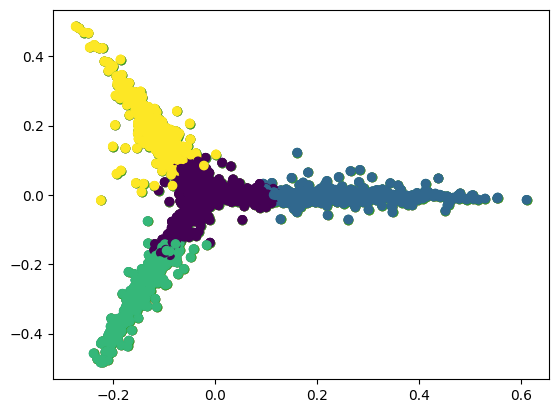

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_mutual_info_score

# Silhouette Score
def silhouette(cluster, n, data):
    true = decompose(n, data)

    if (cluster == 'kmp'):
        pred = kmeansPlus(n, true)
    # elif (cluster == 'skm'):
    #     pred = spherKmeans(n, true)

    silhouetteScore = silhouette_score(true, pred)
    return silhouetteScore

sx = silhouette('kmp', 4, bona_sr_tfidf)
print('silhouette', sx)

# Purity
def purity(cluster, n, data):
    true = decompose(n, data)

    if (cluster == 'kmp'):
        pred = kmeansPlus(n, true)
    # elif (cluster == 'skm'):
    #     pred = spherKmeans(n, true)

    contingencyMatrix = contingency_matrix(true, pred)
    purityScore = np.sum(np.amax(contingencyMatrix, axis=0)) / np.sum(contingencyMatrix)
    return purityScore

px = purity('kmp', 4, bona_sr_tfidf)
print('purity', px)

# AMI
def ami(cluster, n, data):
    true = decompose(n, data)

    if (cluster == 'kmp'):
        pred = kmeansPlus(n, true)
    # elif (cluster == 'skm'):
    #     pred = spherKmeans(n, true)

    amiScore = adjusted_mutual_info_score(true, pred)
    return amiScore

ax = ami('kmp', 4, bona_sr_tfidf)
print('ami', ax)